In [3]:
include("DSLModules.jl");
include("lib.jl");
using  .DSLJulia;

letter = [a-zA-Z]
comment = ⋅\٭(\\.|[^\٭])*\٭⋅                                    > "" 
oldRegex = ⋅\⋅(\\.|[^\⋅])*\⋅⋅                                   > "r\"" * chopFirstLast(x) * "\"" 
quoteRegex = ⋅\'(\\.|[^\'])*\'⋅                                 > "r\"" * mapChars(x -> "[$x]", chopFirstLast(x)) * "\"" 
bracketRegex = ⋅\[(\\.|[^\]])*\]⋅  ('?' | '*' | '+')?      > "r\"" * strings(x) * "\"" 
modifierSimple = '_'+                      > Dict("_" => "hp", "__" => "p")[strings(x)] 
modifier = ('_' | 'w')+                    > Dict("_w" => "hw",  "_" => "hp", "__" => "p", "w" => "w")[strings(x)] 
regexEmpty = modifierSimple                                       > "r\"\"" * strings(x) 
regex = regexEmpty | ((oldRegex | quoteRegex | bracketRegex) modifier?)
parens = '(' _ choice ')' _
single = parens | terminal | nonterminal
nonterminal = letter (letter | [0-9])* _
terminal = regex _ | terminalSpecial
terminalSpecial = '.'                                        > "r\".\""
sepBar = __ '|' _

## Algorithm 

In [5]:
DSL8 = "
y is m×n
X is m×a×n
b₀ = 0ₐ
c₀ = 1
C₀ = 1

λ̃² = 1ₐ
σ² = 1ₘ
D = Diag(σ²)
ψ² = 1ₐ
τ² = 0ₐ
λ² = 1

iterate 10000×:
for j = 1, ..., a
  τ²ⱼ = (2 ψ²ⱼ)/λ²
B₀ = Diag(τ²)
B⁻¹ₙ = B₀⁻¹ + Σᵢ₌₁ⁿ (D⁻¹ Xᵢ)ᵀ Xᵢ
bₙ = Bₙ (B₀⁻¹ b₀ + Σᵢ₌₁ⁿ (D⁻¹ Xᵢ)ᵀ yᵢ)

β ~ 𝒩(bₙ, Bₙ)

ε = 0ₘₙ
for i = 1, ..., n
  εᵢ = yᵢ - Xᵢ β

for l = 1, ..., m
  cₙ = c₀ + n/2
  cₙ = c₀ + n/2    
  Cₙ = C₀ + 1/2 Σᵢ₌₁ⁿ εₗᵢ^2
  σ²ₗ ~ ℐ𝒢(cₙ, Cₙ)
D = Diag(σ²)

for j = 1, ..., a 
  λ̃²ⱼ ~ 𝒢(aᵝ + cᵝ,   1/(aᵝ/cᵝ +  1/ψ²ⱼ))              
  ψ²ⱼ ~ ℐ𝒢(cᵝ + 1/2, λ̃²ⱼ  + (λ² βⱼ^2)/4)           
";


## Rules 


In [7]:
gBasic = raw"
integer = [0-9]+
letter = [A-Za-zβστλψ]
sumsigma = ⋅Σ⋅
nl = ⋅\n⋅ > °° 
indent = '  '? 
"

gJulia = raw"
indexj = 'ⱼ' ‛[j]‛ | 'ₗ'  ‛[l]‛
name = (letter | indexXD)  [ₙ₀²̃ᵝ]* indexj* _
distName = '𝒩'   ‛MvNormal‛
         | 'ℐ𝒢' ‛InverseGamma‛  
         | '𝒢'  ‛Gamma‛
tensor2D = 'y' | 'ε'
tensor3D = 'X'

index3D = tensor3D 'ᵢ' > ‛§1[:, :, i]‛
index2D = tensor2D 'ᵢ' > ‛§1[:, i]‛
index2D2 = tensor2D 'ₗᵢ' > ‛§1[l, i]‛

indexXD = index3D | index2D2 | index2D  

list = '(' _ sum (',' _ sum)* ')' _
distrib = name '~' _ distName list            > ‛§1 = rand(§4§5)‛

isdef2D = name 'is' _ letter '×' letter >  ‛§4, §6 = size(§1)‛
isdef3D = name 'is' _ letter '×' letter '×' letter >  ‛§4, §6, §8 = size(§1)‛
isdef = isdef3D | isdef2D 
defZeroindex = ('ₐ' ‛a‛) | ('ₘ' ‛m‛) | ('ₙ' ‛n‛)
isdefZeros = (name | tensor2D _ | tensor3D _) '=' _ '0' defZeroindex+ > ‛§1 = zeros(°*join(x[5], ',')*°)‛ 
isdefOnes = (name | tensor2D _ | tensor3D _) '=' _ '1' defZeroindex+ >  ‛§1 = ones(°*join(x[5], ',')*°)‛
isdefNums = isdefZeros | isdefOnes

def = name '=' _ sum                          > ‛§1 = §4‛
defInv = name '⁻¹' [ₙ₀²]* _ '=' _ sum         > ‛§1§2§3 = §7\n§1§3 = inversecov(§1§2§3)‛
alloc = (tensor2D | tensor3D) _ 'same as' _ name > ‛§1 = similar(§5)‛

sum = product (_ ([+-] ‛ §1 ‛) _ product)*
product = term ((_ '/' _ | _ ‛ * ‛) term)*

sigmasum = sumsigma ('ᵢ' | '₌' | '₁' | 'ⁿ')+ _ sum > ‛sum(§4 for i in 1:n)‛
sqr = ⋅\^⋅ integer

term = (expr '⁻¹' ‛inversecov(§1)‛)
      | expr ('ᵀ' ‛'‛ | sqr)?
      | sigmasum
      
diagr = ('Diag' ‛Diagonal‛)?
expr = diagr '(' _ sum _ ')' 
       | indexXD
       | tensor2D
       | tensor3D
       | name 
       | integer

outerloop = 'iterate' _ integer'×'  ':' > ‛for iteration ∈ 1:§3‛
loop = 'for' (~',' .)+ ', ..., ' letter+  > ‛§1§2:§4‛

top = (nl* indent (outerloop | loop | distrib | isdef | isdefNums | defInv | def | alloc) _ nl)+      > join(strings.(x), °\n°)
";

## Create rules

In [8]:
DSLJulia.rules([gBasic, gJulia])

code = DSLJulia.parse_dsl(DSL8); # |> first |> print
DSLJulia.print(code)

Tuple{String, String, Union{Nothing, String}}[("integer", "r\"[0-9]+\"", ") |> x -> strings(x)"), ("letter", "r\"[A-Za-zβστλψ]\"", ") |> x -> strings(x)"), ("sumsigma", "r\"Σ\"", ") |> x -> strings(x)"), ("nl", "r\"\\n\"", ") |> x ->  \"\" "), ("indent", "r\"[ ][ ]\"[:?]", ") |> x -> strings(x)")]

----
Tuple{String, String, Union{Nothing, String}}[("indexj", "r\"[ⱼ]\" |> x -> \"[j]\", r\"[ₗ]\" |> x -> \"[l]\"", ") |> x -> strings(x)"), ("name", "(letter, indexXD) & r\"[ₙ₀²̃ᵝ]*\" & indexj[*] & r\"\"hp", ") |> x -> strings(x)"), ("distName", "r\"[𝒩]\" |> x -> \"MvNormal\", r\"[ℐ][𝒢]\" |> x -> \"InverseGamma\", r\"[𝒢]\" |> x -> \"Gamma\"", ") |> x -> strings(x)"), ("tensor2D", "r\"[y]\", r\"[ε]\"", ") |> x -> strings(x)"), ("tensor3D", "r\"[X]\"", ") |> x -> strings(x)"), ("index3D", "tensor3D & r\"[ᵢ]\"", ")  |> x -> \"\$(strings(x[1]))[:, :, i]\""), ("index2D", "tensor2D & r\"[ᵢ]\"", ")  |> x -> \"\$(strings(x[1]))[:, i]\""), ("index2D2", "tensor2D & r\"[ₗ][ᵢ]\"", ")  |> x -> \"\$(stri

## Setup

In [42]:
aᵝ = 0.3
cᵝ = 0.3
βstore = []
## TMP New code
using Random: seed!
using LinearAlgebra
seed!(1)
βₜᵣᵤ = range(-10,10;length=10)
X = 100 * rand(100, 10, 20)
y = hcat([10 .+ X[:, :, i] * βₜᵣᵤ + 100 .* randn(100) for i in 1:20]...);

In [43]:
m, n = size(y)
m, a, n = size(X)
b₀ = zeros(a)
c₀ = 1
C₀ = 1
λ̃² = ones(a)
σ² = ones(m)
D = Diagonal(σ²)
ψ² = ones(a)
τ² = zeros(a)
λ² = 1
for iteration ∈ 1:10000
for j = 1:a
  τ²[j] = (2 * ψ²[j])/λ²
end
B₀ = Diagonal(τ²)
B⁻¹ₙ = inversecov(B₀) + sum((inversecov(D) * X[:, :, i])' * X[:, :, i] for i in 1:n)
Bₙ = inversecov(B⁻¹ₙ)
bₙ = Bₙ * (inversecov(B₀) * b₀ + sum((inversecov(D) * X[:, :, i])' * y[:, i] for i in 1:n))
β = rand(MvNormal(bₙ,Bₙ))
ε = zeros(m,n)
for i = 1:n
  ε[:, i] = y[:, i] - X[:, :, i] * β
end
for l = 1:m
  cₙ = c₀ + n/2
  cₙ = c₀ + n/2
  Cₙ = C₀ + 1/2 * sum(ε[l, i]^2 for i in 1:n)
  σ²[l] = rand(InverseGamma(cₙ,Cₙ))
end
D = Diagonal(σ²)
for j = 1:a
  λ̃²[j] = rand(Gamma(aᵝ + cᵝ,1/(aᵝ/cᵝ + 1/ψ²[j])))
  ψ²[j] = rand(InverseGamma(cᵝ + 1/2,λ̃²[j] + (λ² * β[j]^2)/4))
end
push!(βstore, β )
end

## Plot

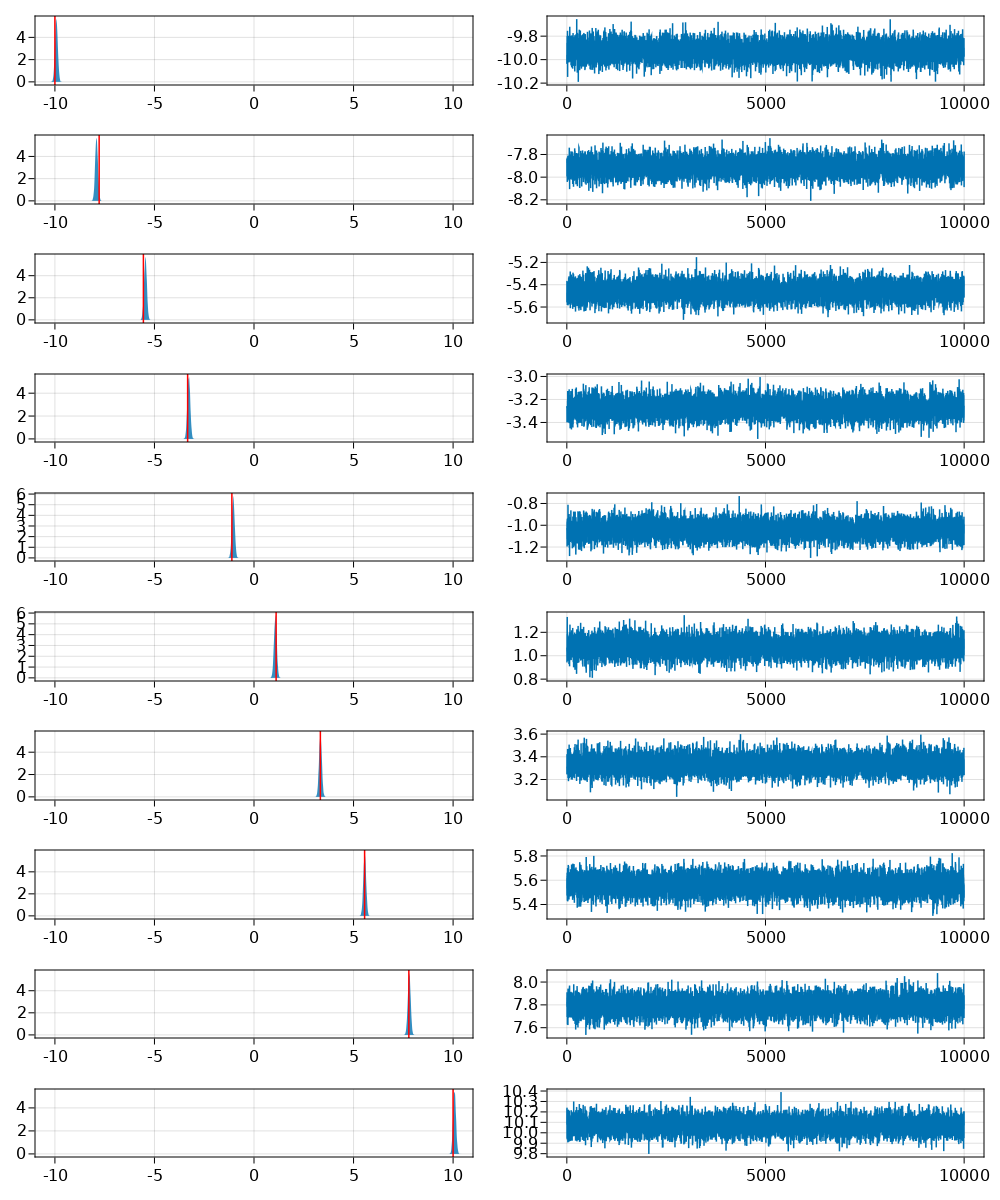

In [57]:
using CairoMakie
f = Figure(resolution = (1000,1200))
axes_dens = [Axis(f[i,1], ylimit = (-10,11)) for i in 1:a]
axes_trace = [Axis(f[i,2]) for i in 1:a]
xlims!.(axes_dens, -11, 11)
for (i,β) in enumerate(eachrow(hcat(βstore...)))
    density!(axes_dens[i], β)
    vlines!(axes_dens[i], βₜᵣᵤ[i], color="red")
    lines!(axes_trace[i], β)
end
f